In [1]:
import numpy as np
import time
import pickle
import os
import matplotlib.pyplot as plt
import warnings
import pandas as pd

warnings.filterwarnings('ignore')

In [2]:
print("----------------Reading the Data-------------------------")
PATH = os.getcwd()
os.chdir('Alphabets/')

X_train = pd.read_csv('train.csv', sep=',', header=None, index_col=False)
X_test = pd.read_csv('test.csv', sep=',', header=None, index_col=False)
np.random.shuffle(X_train.to_numpy())
train_class = X_train[X_train.columns[-1]]
test_actual_class = X_test[X_test.columns[-1]]

X_train = X_train.drop(X_train.columns[-1], axis=1)
X_test = X_test.drop(X_test.columns[-1], axis=1)

print("----------------Data Reading completed-------------------")

os.chdir('../')

X_train = X_train/255
X_test = X_test/255

m = X_train.shape[0] # Number of Training Samples

X_valid = X_train.iloc[(int(0.85*m)):]
valid_class = train_class[(int(0.85*m)):]
X_train = X_train.iloc[0:int(0.85*m)]
train_class = train_class[0:int(0.85*m)]


m = X_train.shape[0] # Number of Training Samples
n = X_train.shape[1] # Number of input features

print("The total number of training samples = {}".format(m))
print("The total number of validation samples = {}".format(X_valid.shape[0]))


print("The number of features = {}".format(n))

----------------Reading the Data-------------------------
----------------Data Reading completed-------------------
The total number of training samples = 11050
The total number of validation samples = 1950
The number of features = 784


In [3]:
#To get the one hot encoding of each label
print("--------Perform 1-hot encoding of class labels------------")

train_class_enc = pd.get_dummies(train_class).to_numpy()
valid_class_enc = pd.get_dummies(valid_class).to_numpy()
test_actual_class_enc = pd.get_dummies(test_actual_class).to_numpy()

--------Perform 1-hot encoding of class labels------------


In [4]:
#Add the intercept term to the data samples both in training and test dataset
X_train = np.hstack((np.ones((m,1)),X_train.to_numpy()))
X_valid = np.hstack((np.ones((X_valid.shape[0],1)), X_valid.to_numpy()))
X_test = np.hstack((np.ones((X_test.shape[0],1)),X_test.to_numpy()))

In [5]:
lr = 0.1
arch_test = [1,5,10,50,100]
arch = [arch_test[3]] #means one hidden layer with 2 perceptrons 
batch_size = 100 # Mini-Batch Size
r = np.max(train_class) + 1 # Default value of the number of classes = 26

In [6]:
#Mini-Batch formation
mini_batch = [(X_train[i:i+batch_size,:], train_class_enc[i:i+batch_size]) for i in range(0, m, batch_size)]
print("The number of mini-batches formed is = {}".format(len(mini_batch)))

The number of mini-batches formed is = 111


In [38]:
#Theta Initialization 
#np.random.seed(1)
def theta_init(arch=[50]):
    theta = []
    for i in range(len(arch)+1):
        if i == 0:
            dim0=n+1
            dim1=arch[i]
        elif (i == len(arch)):
            dim0=arch[i-1]
            dim1 = r
        else:
            dim0=arch[i-1]
            dim1= arch[i]
        theta.append(np.random.normal(0,0.01, (dim0,dim1)))
        #theta.append(0.01*(2*np.random.random((dim0, dim1))-1))
        #theta.append(np.zeros((dim0, dim1)))
        #theta.append(0.01*np.random.standard_normal((dim0, dim1)))
    return theta

In [8]:
def activation(x):
    return 1/(1+np.exp(-x))

In [9]:
def relu_act(x):
    return np.maximum(0.0, x)

In [10]:
def deriv_relu(x):
    #x[x<=0] = -0.01
    x[x<=0] = 0
    x[x>0] = 1
    return x

In [11]:
def leaky_relu_act(x):
    np.where(x > 0, x, x * 0.1) 
    return x

In [12]:
def deriv_leakyRelu(x):
    x[x<=0] = 0.1
    x[x>0] = 1
    return x

In [13]:
def softplus(x):
    return np.log(1+np.exp(x))

In [14]:
def deriv_softplus(x):
    return 1/(1+np.exp(-x))

In [15]:
def forward_prop(data, theta):
    fm = []
    fm.append(data)
    for l in range(len(theta)):
        if (l != len(theta)-1):
            #print("relu")
            fm.append(relu_act(np.dot(fm[l], theta[l])))
        else:
            fm.append(activation(np.dot(fm[l], theta[l])))
            #print("sigmoid output")
    return fm

In [16]:
theta = theta_init([100, 100, 100])
print(theta[3].shape)
fm = forward_prop(X_train, theta)
cost_total(X_train, theta, train_class_enc, m)
cross_entropy_loss(X_train, theta, train_class_enc, m)
#fm = forward_prop(X_train, theta)

(100, 26)


NameError: name 'cost_total' is not defined

In [17]:
def cost_total(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = (1/(2*m))*np.sum((Y-fm[-1])**2)
    return cost

In [18]:
def cross_entropy_loss(X, theta, Y, m):
    fm = forward_prop(X, theta)
    cost = -(1/m)*(np.sum(((Y*np.log(fm[-1]))+((1-Y)*(np.log(1-fm[-1]))))))
    return cost

In [19]:
def calc_accuracy(data, theta, actual_class):
    pred_class = forward_prop(data, theta)
    test_pred_class = pred_class[-1]
    for i in range(len(test_pred_class)):
        test_pred_class[i][test_pred_class[i] == np.max(test_pred_class[i])] = 1
        test_pred_class[i][test_pred_class[i] != np.max(test_pred_class[i])] = 0


    test_acc = 0
    for i in range(len(actual_class)):
        if (np.array_equal(test_pred_class[i], actual_class[i])):
            test_acc+=1
    test_acc /= data.shape[0]

    #print("The Test Accuracy of the model = {}%".format(test_acc*100))
    return (test_acc*100)

In [20]:
epochs = []
train_accuracy = []
valid_accuracy =[]
test_accuracy = []
train_time = []

In [46]:
arch=[100, 100]
lr=0.1
lr0=0.5
theta = theta_init(arch)
print(theta[0].shape, theta[1].shape, theta[2].shape)

(785, 100) (100, 100) (100, 26)


In [43]:
costs = []
epoch = 1
start = time.time()
#cost_init = cost_total(X_train, theta, train_class_enc, m) #Validation loss not giving much info
cost_init = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0]) #Validation loss not giving much info
costs.append(cost_init)
early_stop= 0
while(True):
    count = 0
    lr = lr0/(np.power(epoch, 1/2))
    #if(lr < 0.001): lr = 0.001
    print("learning rate = ", lr)

    print("Initial Cost on dataset for this epoch {} = {}".format(epoch, cost_init))

    for b in mini_batch:
        X_b = b[0]
        Y_b = b[1]
        fm = forward_prop(X_b, theta)
        delta = [None]*len(fm)

        if (count % 60 == 0):
            print("Error on this batch = "+str(cost_total(X_b, theta, Y_b, batch_size)))
        #Backward Propagation

        for l in range(len(fm)-1, 0, -1):
            if (l == len(fm)-1):
                delta[l] = ((1/batch_size)*(Y_b - fm[l])*fm[l]*(1-fm[l]))
                #delta[l] = ((1/batch_size)*((Y_b/fm[l])-((1-Y_b)/(1-fm[l])))*fm[l]*(1-fm[l]))
                #print("delta for last layer=",delta[l].shape)
            else:
                delta[l]=np.dot(delta[l+1], theta[l].T)*deriv_relu(fm[l])
                #print("delta for hidden layer=",delta[l])

        for t in range(len(theta)):
            theta[t] += lr*np.dot(fm[t].T, delta[t+1])
        
        count+=1
    epoch+=1 #Number of epochs
    #ite+=1

    #cost_final = cost_total(X_train, theta, train_class_enc, m)
    cost_final = cost_total(X_valid, theta, valid_class_enc, X_valid.shape[0])
    if(epoch%10==0): costs.append(cost_final)
    print("Cost on val dataset after {} epochs is = {}".format(epoch, cost_final))
    
    if ((cost_final-cost_init) > 0):
        early_stop +=1
    else:
        early_stop=0

    if (early_stop == 30):
        print("cost initial= {} , cost final={} , change in cost= {}".format(cost_init,cost_final, cost_final-cost_init))
        break

    cost_init = cost_final
    
    
epochs.append(epoch)
train_time.append(time.time()-start)
train_accuracy.append(calc_accuracy(X_train, theta, train_class_enc))
valid_accuracy.append(calc_accuracy(X_valid, theta, valid_class_enc))
test_accuracy.append(calc_accuracy(X_test, theta, test_actual_class_enc))
print("\n------------------------------------------------------------------------------")
print("The stats for number of units in the hidden layer arch= {} are as below:".format(arch))
print("------------------------------------------------------------------------------")
print("The number of epochs = {:2.3f}".format(epochs[-1]))
print("The training time = {:2.3f}sec".format(train_time[-1]))
print("The training accuracy is = {:2.3f}%".format(train_accuracy[-1]))
print("The validation accuracy is = {:2.3f}%".format(valid_accuracy[-1]))
print("The test accuracy is = {:2.3f}%".format(test_accuracy[-1]))
print("------------------------------------------------------------------------------\n")

learning rate =  0.5
Initial Cost on dataset for this epoch 1 = 3.250300580987951
Error on this batch = 3.250320585983516
Error on this batch = 0.49998318754910404
Cost on val dataset after 2 epochs is = 0.4999722463171738
learning rate =  0.35355339059327373
Initial Cost on dataset for this epoch 2 = 0.4999722463171738
Error on this batch = 0.49999298528631364
Error on this batch = 0.49998230577989483
Cost on val dataset after 3 epochs is = 0.49997109974837095
learning rate =  0.2886751345948129
Initial Cost on dataset for this epoch 3 = 0.49997109974837095
Error on this batch = 0.49999256443452733
Error on this batch = 0.4999815751536351
Cost on val dataset after 4 epochs is = 0.4999700871984247
learning rate =  0.25
Initial Cost on dataset for this epoch 4 = 0.4999700871984247
Error on this batch = 0.49999218662780903
Error on this batch = 0.49998091335397987
Cost on val dataset after 5 epochs is = 0.4999691482355044
learning rate =  0.22360679774997896
Initial Cost on dataset for t

Error on this batch = 0.4999603344321944
Cost on val dataset after 36 epochs is = 0.4999389616519373
learning rate =  0.08333333333333333
Initial Cost on dataset for this epoch 36 = 0.4999389616519373
Error on this batch = 0.4999781951833323
Error on this batch = 0.4999594071156056
Cost on val dataset after 37 epochs is = 0.49993759598466364
learning rate =  0.08219949365267865
Initial Cost on dataset for this epoch 37 = 0.49993759598466364
Error on this batch = 0.4999774898752588
Error on this batch = 0.49995844947958434
Cost on val dataset after 38 epochs is = 0.49993618572078136
learning rate =  0.08111071056538127
Initial Cost on dataset for this epoch 38 = 0.49993618572078136
Error on this batch = 0.499976754326319
Error on this batch = 0.4999574597120154
Cost on val dataset after 39 epochs is = 0.49993472805796707
learning rate =  0.08006407690254357
Initial Cost on dataset for this epoch 39 = 0.49993472805796707
Error on this batch = 0.4999759865005519
Error on this batch = 0.49

Error on this batch = 0.49988728719639397
Cost on val dataset after 70 epochs is = 0.49983103588808364
learning rate =  0.05976143046671968
Initial Cost on dataset for this epoch 70 = 0.49983103588808364
Error on this batch = 0.4999059115318373
Error on this batch = 0.49988184943413205
Cost on val dataset after 71 epochs is = 0.49982295689231426
learning rate =  0.05933908290969266
Initial Cost on dataset for this epoch 71 = 0.49982295689231426
Error on this batch = 0.49989940851222614
Error on this batch = 0.49987590782612445
Cost on val dataset after 72 epochs is = 0.49981411946177917
learning rate =  0.05892556509887897
Initial Cost on dataset for this epoch 72 = 0.49981411946177917
Error on this batch = 0.4998921516598267
Error on this batch = 0.49986939000309505
Cost on val dataset after 73 epochs is = 0.499804410553468
learning rate =  0.058520573598065284
Initial Cost on dataset for this epoch 73 = 0.499804410553468
Error on this batch = 0.49988401175335884
Error on this batch =

Error on this batch = 0.4988701470025497
Cost on val dataset after 104 epochs is = 0.49573302413574916
learning rate =  0.04902903378454601
Initial Cost on dataset for this epoch 104 = 0.49573302413574916
Error on this batch = 0.4907331599448911
Error on this batch = 0.49884627987956565
Cost on val dataset after 105 epochs is = 0.49564560415150816
learning rate =  0.048795003647426664
Initial Cost on dataset for this epoch 105 = 0.49564560415150816
Error on this batch = 0.49052699704290703
Error on this batch = 0.4988257704735284
Cost on val dataset after 106 epochs is = 0.4955658482764615
learning rate =  0.04856429311786321
Initial Cost on dataset for this epoch 106 = 0.4955658482764615
Error on this batch = 0.4903409342750114
Error on this batch = 0.49880768299685435
Cost on val dataset after 107 epochs is = 0.49549283073079736
learning rate =  0.04833682445228318
Initial Cost on dataset for this epoch 107 = 0.49549283073079736
Error on this batch = 0.4901725962792338
Error on this 

Error on this batch = 0.49852324098451306
Cost on val dataset after 138 epochs is = 0.4942067104648728
learning rate =  0.04256282653793743
Initial Cost on dataset for this epoch 138 = 0.4942067104648728
Error on this batch = 0.48747172956466395
Error on this batch = 0.49851229914853257
Cost on val dataset after 139 epochs is = 0.4941742285834865
learning rate =  0.042409446483998546
Initial Cost on dataset for this epoch 139 = 0.4941742285834865
Error on this batch = 0.4874092392197434
Error on this batch = 0.4985010860251887
Cost on val dataset after 140 epochs is = 0.49414179167358446
learning rate =  0.042257712736425826
Initial Cost on dataset for this epoch 140 = 0.49414179167358446
Error on this batch = 0.4873469896295785
Error on this batch = 0.49848930919934903
Cost on val dataset after 141 epochs is = 0.4941094739410419
learning rate =  0.04210759605332595
Initial Cost on dataset for this epoch 141 = 0.4941094739410419
Error on this batch = 0.48728497082455263
Error on this b

Error on this batch = 0.4978477310042395
Cost on val dataset after 172 epochs is = 0.49296919185925553
learning rate =  0.038124642583151166
Initial Cost on dataset for this epoch 172 = 0.49296919185925553
Error on this batch = 0.48505570121913866
Error on this batch = 0.49781331719227495
Cost on val dataset after 173 epochs is = 0.4929197204838961
learning rate =  0.038014296063485276
Initial Cost on dataset for this epoch 173 = 0.4929197204838961
Error on this batch = 0.48496217508036554
Error on this batch = 0.4977776322128878
Cost on val dataset after 174 epochs is = 0.4928687787456167
learning rate =  0.03790490217894517
Initial Cost on dataset for this epoch 174 = 0.4928687787456167
Error on this batch = 0.4848661857416218
Error on this batch = 0.4977404838775721
Cost on val dataset after 175 epochs is = 0.4928162610753039
learning rate =  0.03779644730092272
Initial Cost on dataset for this epoch 175 = 0.4928162610753039
Error on this batch = 0.4847677925907488
Error on this bat

Error on this batch = 0.49547100367018204
Cost on val dataset after 206 epochs is = 0.489859531910643
learning rate =  0.034836650714580884
Initial Cost on dataset for this epoch 206 = 0.489859531910643
Error on this batch = 0.4798325316080728
Error on this batch = 0.4953522883468962
Cost on val dataset after 207 epochs is = 0.4897152541493147
learning rate =  0.034752402342845795
Initial Cost on dataset for this epoch 207 = 0.4897152541493147
Error on this batch = 0.47960854032564676
Error on this batch = 0.4952313080057735
Cost on val dataset after 208 epochs is = 0.48956951624768913
learning rate =  0.03466876226407682
Initial Cost on dataset for this epoch 208 = 0.48956951624768913
Error on this batch = 0.4793835892981591
Error on this batch = 0.4951087940921018
Cost on val dataset after 209 epochs is = 0.4894228188885598
learning rate =  0.03458572319330373
Initial Cost on dataset for this epoch 209 = 0.4894228188885598
Error on this batch = 0.47915832129668817
Error on this batch

Error on this batch = 0.49206095537759326
Cost on val dataset after 240 epochs is = 0.48596470050377366
learning rate =  0.03227486121839514
Initial Cost on dataset for this epoch 240 = 0.48596470050377366
Error on this batch = 0.4739657219040933
Error on this batch = 0.4920028638969535
Cost on val dataset after 241 epochs is = 0.48589897713229707
learning rate =  0.03220783132004154
Initial Cost on dataset for this epoch 241 = 0.48589897713229707
Error on this batch = 0.4738639436490294
Error on this batch = 0.49194692655953093
Cost on val dataset after 242 epochs is = 0.4858353720745522
learning rate =  0.03214121732666125
Initial Cost on dataset for this epoch 242 = 0.4858353720745522
Error on this batch = 0.47376520577556713
Error on this batch = 0.4918930153217293
Cost on val dataset after 243 epochs is = 0.48577378165895196
learning rate =  0.032075014954979206
Initial Cost on dataset for this epoch 243 = 0.48577378165895196
Error on this batch = 0.47366943540171386
Error on this

Error on this batch = 0.490915853311557
Cost on val dataset after 274 epochs is = 0.4845437150961798
learning rate =  0.03020610466650885
Initial Cost on dataset for this epoch 274 = 0.4845437150961798
Error on this batch = 0.47163418008187735
Error on this batch = 0.49089856385467073
Cost on val dataset after 275 epochs is = 0.4845183123569713
learning rate =  0.030151134457776358
Initial Cost on dataset for this epoch 275 = 0.4845183123569713
Error on this batch = 0.4715897665979689
Error on this batch = 0.4908817885961693
Cost on val dataset after 276 epochs is = 0.4844934784041603
learning rate =  0.0300964632714423
Initial Cost on dataset for this epoch 276 = 0.4844934784041603
Error on this batch = 0.4715462200886432
Error on this batch = 0.49086547768836997
Cost on val dataset after 277 epochs is = 0.48446922552918786
learning rate =  0.030042088406305484
Initial Cost on dataset for this epoch 277 = 0.48446922552918786
Error on this batch = 0.4715036285741544
Error on this batch

Error on this batch = 0.49052775128715315
Cost on val dataset after 308 epochs is = 0.48391728236945636
learning rate =  0.028490144114909487
Initial Cost on dataset for this epoch 308 = 0.48391728236945636
Error on this batch = 0.47052009127691186
Error on this batch = 0.49052051089631604
Cost on val dataset after 309 epochs is = 0.4839041873083247
learning rate =  0.028444006199428714
Initial Cost on dataset for this epoch 309 = 0.4839041873083247
Error on this batch = 0.47049648143770184
Error on this batch = 0.49051344456271795
Cost on val dataset after 310 epochs is = 0.48389130021793386
learning rate =  0.02839809171235324
Initial Cost on dataset for this epoch 310 = 0.48389130021793386
Error on this batch = 0.4704733083613665
Error on this batch = 0.4905065292092749
Cost on val dataset after 311 epochs is = 0.48387862640214724
learning rate =  0.028352398856187136
Initial Cost on dataset for this epoch 311 = 0.48387862640214724
Error on this batch = 0.4704505263714438
Error on t

Error on this batch = 0.4903485085979875
Cost on val dataset after 342 epochs is = 0.48356804561854955
learning rate =  0.02703690352179376
Initial Cost on dataset for this epoch 342 = 0.48356804561854955
Error on this batch = 0.46989147251502794
Error on this batch = 0.4903447729141591
Cost on val dataset after 343 epochs is = 0.48356012720750263
learning rate =  0.02699746235780194
Initial Cost on dataset for this epoch 343 = 0.48356012720750263
Error on this batch = 0.469877150653285
Error on this batch = 0.4903411304239916
Cost on val dataset after 344 epochs is = 0.4835522863219069
learning rate =  0.026958193300859603
Initial Cost on dataset for this epoch 344 = 0.4835522863219069
Error on this batch = 0.4698629953777537
Error on this batch = 0.49033752892343585
Cost on val dataset after 345 epochs is = 0.48354455926083423
learning rate =  0.026919095102908276
Initial Cost on dataset for this epoch 345 = 0.48354455926083423
Error on this batch = 0.46984910149022197
Error on this 

Error on this batch = 0.4902509469494685
Cost on val dataset after 376 epochs is = 0.4833444434307385
learning rate =  0.025785531156469834
Initial Cost on dataset for this epoch 376 = 0.4833444434307385
Error on this batch = 0.46948916823306563
Error on this batch = 0.49024879806953536
Cost on val dataset after 377 epochs is = 0.4833390432123322
learning rate =  0.025751310131230238
Initial Cost on dataset for this epoch 377 = 0.4833390432123322
Error on this batch = 0.46947946041178745
Error on this batch = 0.49024668190495085
Cost on val dataset after 378 epochs is = 0.4833337069823203
learning rate =  0.025717224993681984
Initial Cost on dataset for this epoch 378 = 0.4833337069823203
Error on this batch = 0.4694698669101962
Error on this batch = 0.49024459843075185
Cost on val dataset after 379 epochs is = 0.4833284122959894
learning rate =  0.025683274846875707
Initial Cost on dataset for this epoch 379 = 0.4833284122959894
Error on this batch = 0.46946032792891623
Error on this 

KeyboardInterrupt: 

In [44]:
calc_accuracy(X_test, theta, test_actual_class_enc)

3.8461538461538463

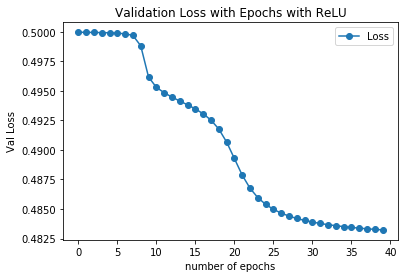

In [45]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Validation Loss with Epochs with ReLU")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Loss')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Val Loss")

plt.legend()
plt.savefig("plots/partd/relu_val_adapt_sqrt.png", dpi=1000, bbox_inches='tight')
#plt.show()

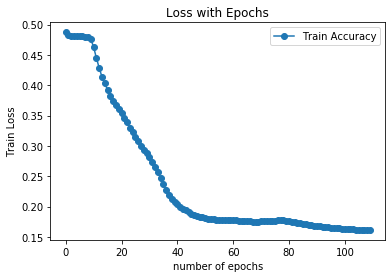

In [151]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_title("Loss with Epochs")
x = np.arange(0,len(costs[1:]))
ax.plot(x, costs[1:], marker='o', label='Train Accuracy')
ax.set_xlabel("number of epochs")
ax.set_ylabel("Train Loss")

plt.legend()
#plt.savefig("accuracy_HiddenUnit_val20per.png", dpi=1000, bbox_inches='tight')
plt.show()